In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import pint_xarray
import cf_xarray as cfxr

In [2]:
from pint import application_registry as ureg

In [3]:
from dask.distributed import Client, LocalCluster
client = Client()
client

<Client: 'tcp://127.0.0.1:38313' processes=7 threads=14, memory=63.00 GiB>

In [4]:
straits = {'Drake Passage': [ -69.9,      -69.9,     -71.6, -51.0],
           'Lombok':        [-244.5, -242.5,  -8.6,  -8.6],
           'Ombai' :        [-236.5, -236.5,  -10,  -8.7],
           'Timor' :        [-234.9, -234.9, -14.4,  -10],
           'Denmark' :      [-42,               -22,  65.8,  65.8],
           'Bering' :       [-172,             -167,  65.8,  65.8],
            }

In [5]:
ρ0 = 1036 * ureg.kilogram / ureg.meter**3

In [6]:
def calc_transport(DS, strait):
    """
    Calculate barotropic transport across a given 
    line of latitude or longitude.
     
    Designed for flow through straits.
    """
    tx_trans = DS.tx_trans
    ty_trans = DS.ty_trans
    
    start_time=DS.time[0]
    end_time=DS.time[-1]
    xmin, xmax, ymin, ymax = straits[strait]
    
    if ymax >= 65:
        logging.warning('North of 65N the tripolar grid geometry brings complications and `.sum(''xt_ocean'')` is wrong!')
    
    print('Calculating: {} transport'.format(strait))
    
    if xmin == xmax:                
        tx_trans = tx_trans.pint.quantify()

        transport = (tx_trans / ρ0).sel(time=slice(start_time, end_time))\
                                   .sel(xu_ocean=xmin, method='nearest')\
                                   .sel(yt_ocean=slice(ymin, ymax))\
                                   .sum('st_ocean').sum('yt_ocean')
        transport.attrs['long_name'] = 'zonal transport'

    elif ymin == ymax:
        ty_trans = ty_trans.pint.quantify()
        
        transport = (ty_trans / ρ0).sel(time=slice(start_time, end_time))\
                                   .sel(yu_ocean=ymin, method='nearest')\
                                   .sel(xt_ocean=slice(xmin, xmax))\
                                   .sum('st_ocean').sum('xt_ocean')
        transport.attrs['long_name'] = 'meridional transport'
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or constant longitude')
    
    transport = transport.pint.to('sverdrup')
    transport = transport.compute()
       
    return transport

In [7]:
def ITF_trans(DS):
    L = calc_transport(DS, "Lombok")
    T = calc_transport(DS, "Timor")
    O = calc_transport(DS, "Ombai")
    return L+T+O
    

In [8]:
ctrl = xr.open_mfdataset("/g/data/hh5/tmp/zg0866/cm000_APP4_archive/cm000/history/ocn/ocean_month.nc-*",
                         use_cftime=True, chunks= {"time":240})

In [9]:
ctrl

<xarray.Dataset>
Dimensions:                          (xt_ocean: 360, yt_ocean: 300, time: 2412,
                                      nv: 2, xu_ocean: 360, yu_ocean: 300,
                                      st_ocean: 50, st_edges_ocean: 51,
                                      sw_ocean: 50, sw_edges_ocean: 51,
                                      grid_xu_ocean: 360, grid_yt_ocean: 300,
                                      potrho: 80, potrho_edges: 81,
                                      grid_xt_ocean: 360, grid_yu_ocean: 300)
Coordinates: (12/20)
  * xt_ocean                         (xt_ocean) float64 -279.5 -278.5 ... 79.5
  * yt_ocean                         (yt_ocean) float64 -77.88 -77.63 ... 89.77
  * time                             (time) object 0950-01-16 12:00:00 ... 11...
  * nv                               (nv) float64 1.0 2.0
  * xu_ocean                         (xu_ocean) float64 -279.0 -278.0 ... 80.0
  * yu_ocean                         (yu_ocean) float64 -77.75 -77.51 ... 90.0
    ...                               ...
  * grid_xt_ocean                    (grid_xt_ocean) float64 -279.5 ... 79.5
  * grid_yu_ocean                    (grid_yu_ocean) float64 -77.75 ... 90.0
    geolat_c                         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolon_c                         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolat_t                         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolon_t                         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Data variables: (12/261)
    ht                               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    hu                               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    dxt                              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    dyt                              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    dxu                              (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    dyu                              (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    ...                               ...
    salt_rivermix                    (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    salt_sigma_diff                  (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    average_T1                       (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2                       (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_DT                       (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    time_bounds                      (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    filename:   /scratch/w97/zg0866/archive/cm000/history/ocn/ocean_month.nc-...
    title:      AusCOM_CMIP5
    grid_type:  regular
    grid_tile:  N/A

In [10]:
VC = xr.open_mfdataset("/g/data/e14/sm2435/PACE_OC/cy286/history/ocn/ocean_month.nc-*",
                         use_cftime=True, chunks= {"time":240})

In [11]:
OC = xr.open_mfdataset("/g/data/e14/sm2435/PACE_OC/cw323/history/ocn/ocean_month.nc-*",
                         use_cftime=True, chunks= {"time":240})

In [13]:
MC = xr.open_mfdataset("/g/data/hh5/tmp/zg0866/pacemaker/cs947/history/ocn/ocean_month.nc-*",
                         use_cftime=True, chunks= {"time":240})

In [14]:
VC_ITF = ITF_trans(VC)

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


In [15]:
OC_ITF = ITF_trans(OC)

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


In [16]:
MC_ITF = ITF_trans(MC)

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


In [17]:
ctrl_ITF = ITF_trans(ctrl)

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


Text(0.5, 1.0, 'ITF strength')

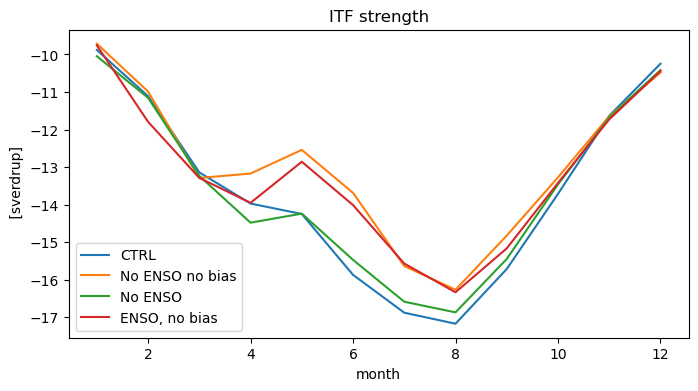

In [18]:
plt.figure(figsize = (8,4))
ctrl_ITF.groupby("time.month").mean("time").plot(label = "CTRL")
OC_ITF.groupby("time.month").mean("time").plot(label = "No ENSO no bias")
MC_ITF.groupby("time.month").mean("time").plot(label = "No ENSO")
VC_ITF.groupby("time.month").mean("time").plot(label = "ENSO, no bias")
plt.legend()
plt.title("ITF strength")

In [19]:
def calc_heat_transport(DS, strait):
    """
    Calculate barotropic transport across a given 
    line of latitude or longitude.
     
    Designed for flow through straits.
    """
    tx_trans = DS.temp_xflux_adv * 1e-15
    ty_trans = DS.temp_yflux_adv * 1e-15
    
    tx_trans = tx_trans.assign_attrs(units='PettaWatts')
    ty_trans = ty_trans.assign_attrs(units='PettaWatts')
    
    start_time=DS.time[0]
    end_time=DS.time[-1]
    xmin, xmax, ymin, ymax = straits[strait]
    
    if ymax >= 65:
        logging.warning('North of 65N the tripolar grid geometry brings complications and `.sum(''xt_ocean'')` is wrong!')
    
    print('Calculating: {} transport'.format(strait))
    
    if xmin == xmax:                
        #tx_trans = tx_trans.pint.quantify()

        transport = (tx_trans).sel(time=slice(start_time, end_time))\
                                   .sel(xu_ocean=xmin, method='nearest')\
                                   .sel(yt_ocean=slice(ymin, ymax))\
                                   .sum('st_ocean').sum('yt_ocean')
        transport.attrs['long_name'] = 'zonal heat transport'

    elif ymin == ymax:
        #ty_trans = ty_trans.pint.quantify()
        
        transport = (ty_trans).sel(time=slice(start_time, end_time))\
                                   .sel(yu_ocean=ymin, method='nearest')\
                                   .sel(xt_ocean=slice(xmin, xmax))\
                                   .sum('st_ocean').sum('xt_ocean')
        transport.attrs['long_name'] = 'meridional heat transport'
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or constant longitude')
    
    #transport = transport.pint.to('watts')
    #area = 
    
    #transport = transport/area
    transport = transport.compute()
       
    return transport

In [20]:
def ITF_heat(DS):
    L = calc_heat_transport(DS, "Lombok")
    T = calc_heat_transport(DS, "Timor")
    O = calc_heat_transport(DS, "Ombai")
    return {"Timor": T, "Lombok": L, "Ombai": O}
    

In [21]:
VC_ih = ITF_heat(VC)

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


In [22]:
OC_ih = ITF_heat(OC)

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


In [23]:
MC_ih = ITF_heat(MC)

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


In [24]:
ctrl_ih = ITF_heat(ctrl)

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


In [25]:
exps = {"ctrl": ctrl_ih, "No ENSO no Bias": OC_ih, "No ENSO": MC_ih, "ENSO no bias": VC_ih}

Text(0.5, 1.0, 'ITF heat flux (PW)')

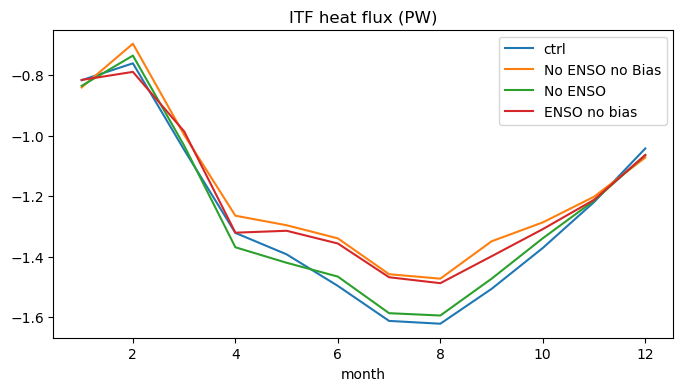

In [26]:
plt.figure(figsize = (8,4))
for exp in exps.keys():
    #unpack each variable
    run = exps[exp]
    T = run["Timor"]
    L = run["Lombok"]
    O = run["Ombai"]
    itf = T+O+L
    itf.groupby("time.month").mean("time").plot(label = exp)
plt.legend()
plt.title("ITF heat flux (PW)")    
    


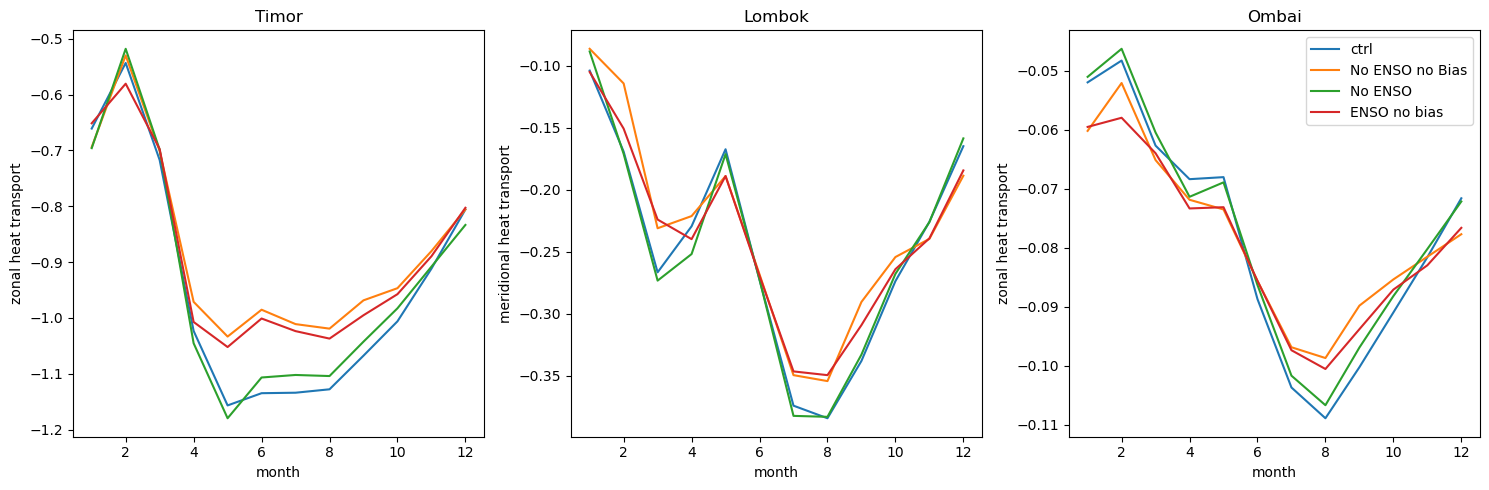

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for exp in exps.keys():
    #unpack each variable
    run = exps[exp]
    for i, strait in enumerate(run.keys()):
        st = run[strait]
        exp_group = st.groupby("time.month").mean("time")
        # Plot the data on the corresponding subplot
        exp_group.plot(ax=axes[i], label=exp)
        axes[i].set_title(strait)
axes[-1].legend()
plt.tight_layout()

In [29]:
#load in zonal wind (wind speed and wind stress

In [30]:
ctrl_u = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_u/ctrl_u*.nc",
                          use_cftime=True)

In [31]:
ctrl_u = ctrl_u.fld_s30i201.compute()

In [32]:
VC_u = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_u/VC_u*.nc",
                          use_cftime=True, chunks= {"time":240})
VC_u = VC_u.fld_s30i201.compute()

In [33]:
#now get the 1000hpa winds

In [87]:

ctrl_uc = ctrl_u.groupby("time.month").mean("time")
VC_uc = VC_u.groupby("time.month").mean("time")

In [88]:
ctrl_u1000 = ctrl_uc.sel(pressure = 100000)
VC_u1000 = VC_uc.sel(pressure = 100000)

In [89]:
ctrl_u1000 = ctrl_u1000.reindex(season=['MAM', 'JJA', 'SON', 'DJF'])
VC_u1000 = VC_u1000.reindex(season=['MAM', 'JJA', 'SON', 'DJF'])

In [92]:
#take index in the equatorial pacific
def pacific_region(DS):
    return DS.sel(lat_v=slice(-5, 5),lon_u=slice(130, 240)).mean(['lat_v', 'lon_u'])
     

Text(0.5, 1.0, 'zonal wind 130E - 120W')

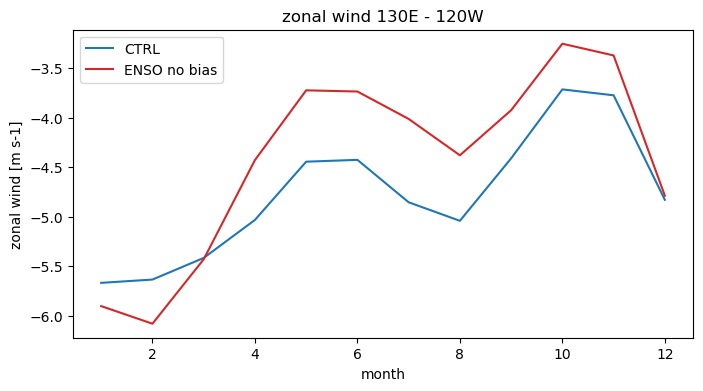

In [93]:
plt.figure(figsize = (8,4))
pacific_region(ctrl_u1000).plot(label="CTRL")
pacific_region(VC_u1000).plot(label="ENSO no bias", c= "tab:red")
#pacific_region(VC_u1000).plot()
plt.legend()
plt.ylabel("zonal wind [m s-1]")
plt.title("zonal wind 130E - 120W, 5S-5N")

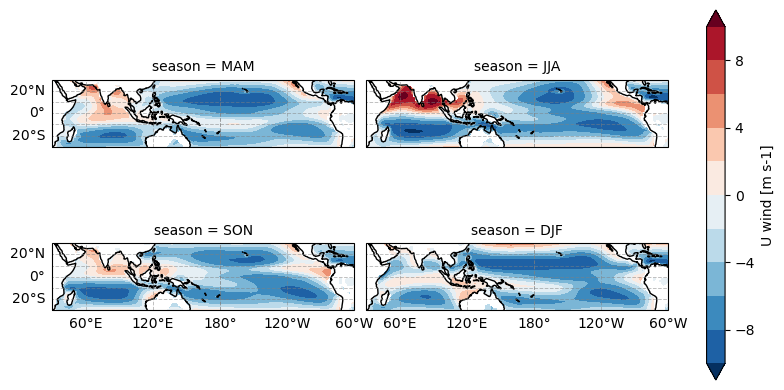

In [85]:
fg = (ctrl_u1000).sel(lat_v=slice(-30, 30),lon_u=slice(30, 300)).plot.contourf(col = "season", col_wrap = 2, 
                                                    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)},
                                        figsize = (8,4),
                                            vmin = -10, levels = 11, extend = "both",
                                                cbar_kwargs={'label': "U wind [m s-1]"})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    #ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False

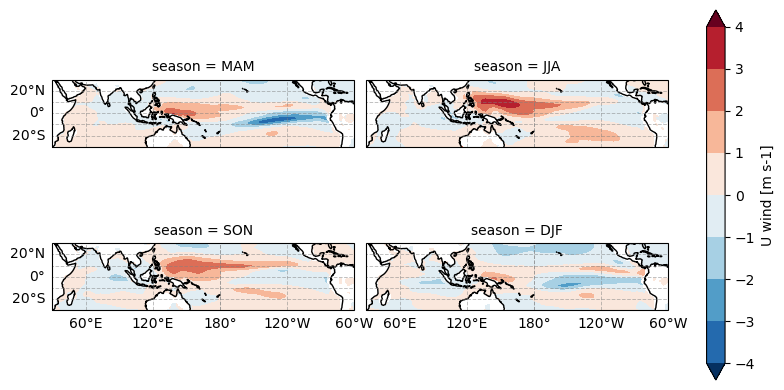

In [86]:
fg = (VC_u1000-ctrl_u1000).sel(lat_v=slice(-30, 30),lon_u=slice(30, 300)).plot.contourf(col = "season", col_wrap = 2, 
                                                    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)},
                                        figsize = (8,4),
                                                   vmin = -4, levels = 9, extend = "both",
                                                    cbar_kwargs={'label': "U wind [m s-1]"})
                                                                                    
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    #ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False

TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

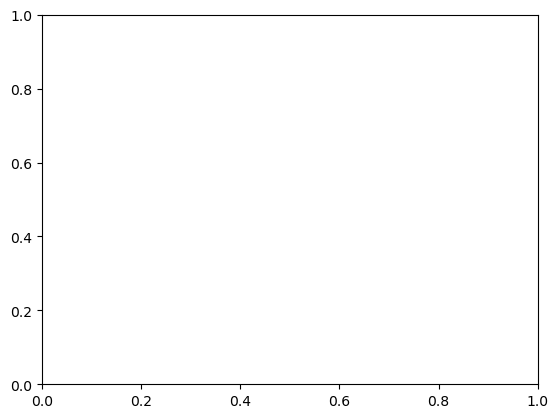

In [57]:
(pacific_region(VC_u1000) - pacific_region(ctrl_u1000)).plot()
#pacific_region(VC_u1000).plot()
plt.axhline(0)

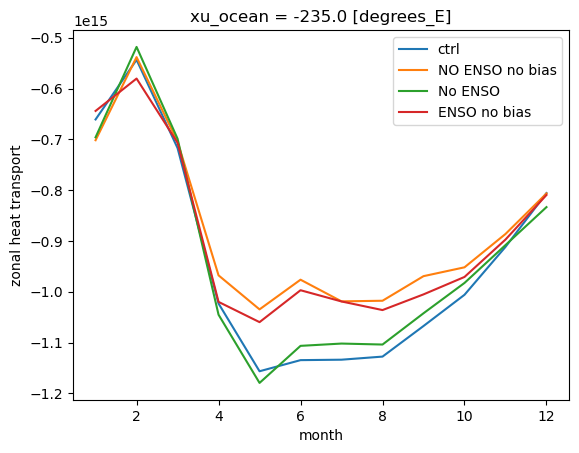

In [26]:
testc.groupby("time.month").mean("time").plot(label = "ctrl")
testO.groupby("time.month").mean("time").plot(label = "NO ENSO no bias")
testM.groupby("time.month").mean("time").plot(label = 'No ENSO')
testV.groupby("time.month").mean("time").plot(label = "ENSO no bias")
plt.legend()
plt.title("Timor strait heat transport")

In [99]:
L = calc_transport(DS, "Lombok")
T = calc_transport(DS, "Timor")
O = calc_transport(DS, "Ombai")

Calculating: Lombok transport
Calculating: Timor transport
Calculating: Ombai transport


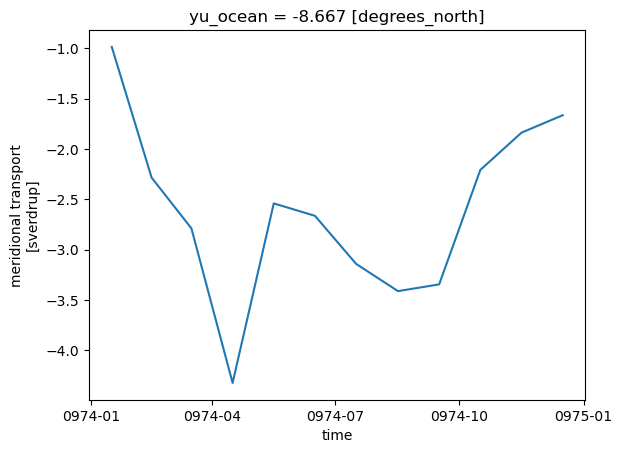

In [95]:
L.plot()

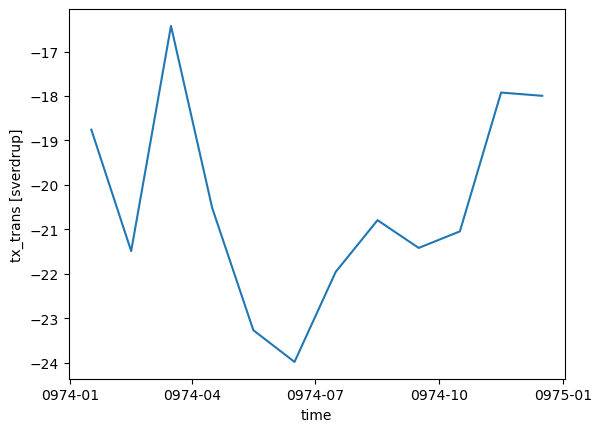

In [93]:
(T+T+O).plot()

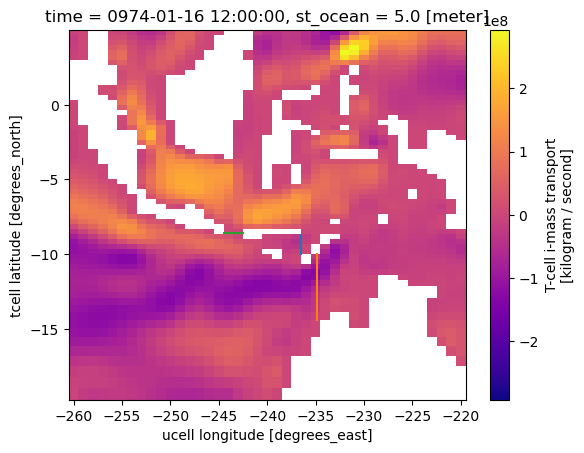

In [91]:
tx_trans.sel(xu_ocean=slice(-260, -220))\
             .sel(yt_ocean=slice(-20,5))\
             [0,0].plot(cmap = 'plasma')
xmin, xmax, ymin, ymax = straits['Ombai']
plt.plot([xmin, xmax], [ymin, ymax],  linestyle='-')
xmin, xmax, ymin, ymax = straits['Timor']
plt.plot([xmin, xmax], [ymin, ymax],  linestyle='-')
xmin, xmax, ymin, ymax = straits['Lombok']
plt.plot([xmin, xmax], [ymin, ymax],  linestyle='-')

In [5]:
###Look at Ocean heat content in the experiemnts
### From Maurice:
rho_0 = 1035 # kg m-3
C_p = 3992.1 # J kg-1 K-1

# temp = xr.open_mfdataset(/path/to/file.nc)
# dzt = xr.open_mfdataset(/path/to/file.nc)
# area_t = xr.open_dataset(/path/to/file.nc)
# # calculate OHC
# OHC = (rho_0*C_p*temp*area_t*dzt).sel(st_ocean=slice(0.,2000.)).sum(['xt_ocean','yt_ocean','st_ocean'])

In [6]:
#Fucntion that Selects area to calcualte ocean heat content

In [7]:
test = ctrl['sst'].drop(["geolat_t", "geolon_t"])

In [8]:
test[0]

<xarray.DataArray 'sst' (yt_ocean: 300, xt_ocean: 360)>
dask.array<getitem, shape=(300, 360), dtype=float32, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    time      object 0950-01-16 12:00:00
Attributes:
    long_name:      Potential temperature
    units:          degrees K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [9]:
def roll_lon(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean'] + 0) %360
    df = df.sortby(df.xt_ocean)
    
    
    return df

In [97]:
test = roll_lon(test)

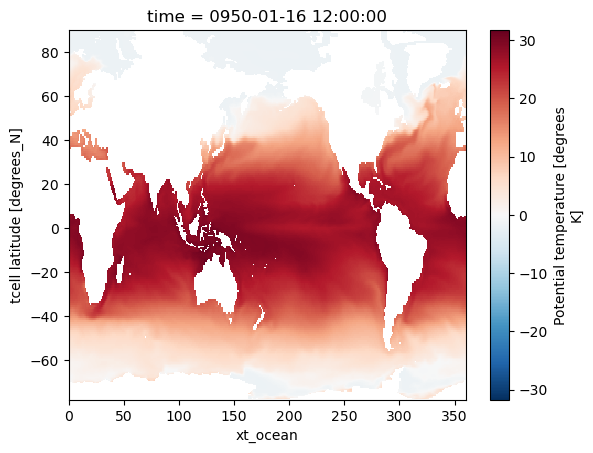

In [98]:
test[0].plot()

In [102]:
def OHC_mask(ds, depth, mask ):
    temp = ds.temp.drop(["geolat_t", "geolon_t"])
    dzt = ds.dht.drop(["geolat_t", "geolon_t"])
    area_t = ds.area_t.drop(["geolat_t", "geolon_t"])
    rho_0 = 1035 # kg m-3
    C_p = 3992.1 # J kg-1 K-1
    intermediate = (rho_0*C_p*temp*area_t*dzt).sel(st_ocean=slice(0.,depth))
    #roll_lon of intermediate array
    int_roll = roll_lon(intermediate)
    #mask = roll_lon(mask)
    #mask array
    box = int_roll.where(mask >0)    
    #select box    
    #box = int_roll.sel(xt_ocean=slice(lon1, lon2),yt_ocean=slice(lat1, lat2))
    #now get OHC by integrating
    OHC =box.sum(['xt_ocean','yt_ocean','st_ocean'])
    return OHC

In [103]:
basin_mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/basin_mask_20111103.nc")
basin_mask = basin_mask.BASIN_MASK[0].drop("ST_OCEAN1_1")
PO = basin_mask.where(basin_mask ==3)
IO = basin_mask.where(basin_mask ==5)

In [104]:
PO = PO.rename({'YT_OCEAN': 'yt_ocean', 'XT_OCEAN': 'xt_ocean'})
IO = IO.rename({'YT_OCEAN': 'yt_ocean', 'XT_OCEAN': 'xt_ocean'})

In [105]:
IO = roll_lon(IO)
PO = roll_lon(PO)

In [106]:
PO_HC = OHC_mask(ctrl, 300, PO)

In [107]:
IO_HC = OHC_mask(ctrl, 300, IO)

In [120]:
IO_HC_v = OHC_mask(VC, 300, IO)
PO_HC_v = OHC_mask(VC, 300, PO)

In [121]:
IO_HC_v = IO_HC_v.compute()

In [122]:
PO_HC_v = PO_HC_v.compute()

In [108]:
PO_HC = PO_HC.compute()

In [109]:
IO_HC = IO_HC.compute()

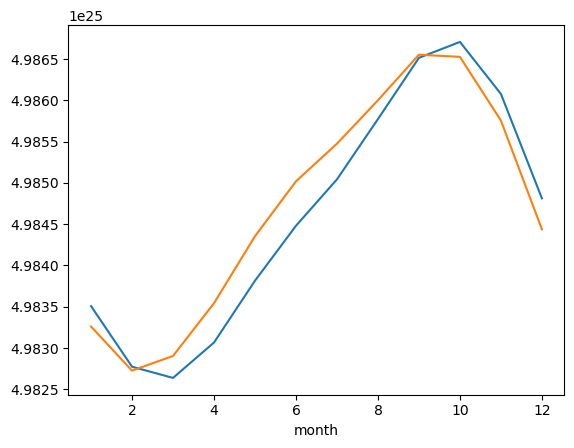

In [125]:
PO_HC.sel(time = slice("0951-01-01", "1009-12-31")).groupby("time.month").mean("time").plot()
PO_HC_v.groupby("time.month").mean("time").plot()

In [129]:
IO_HC.sel(time = slice("0951-01-01", "1009-12-31")).sum("time") - IO_HC_v.sum("time")

<xarray.DataArray ()>
array(2.7531397e+24, dtype=float32)

In [128]:
IO_HC_v.sum("time")

<xarray.DataArray ()>
array(1.1560318e+28, dtype=float32)

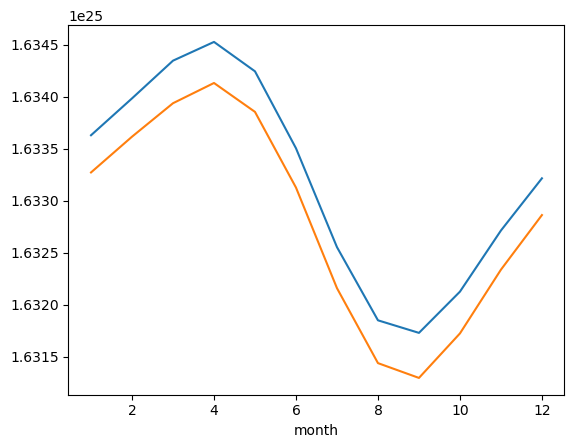

In [126]:
IO_HC.sel(time = slice("0951-01-01", "1009-12-31")).groupby("time.month").mean("time").plot()
IO_HC_v.groupby("time.month").mean("time").plot()

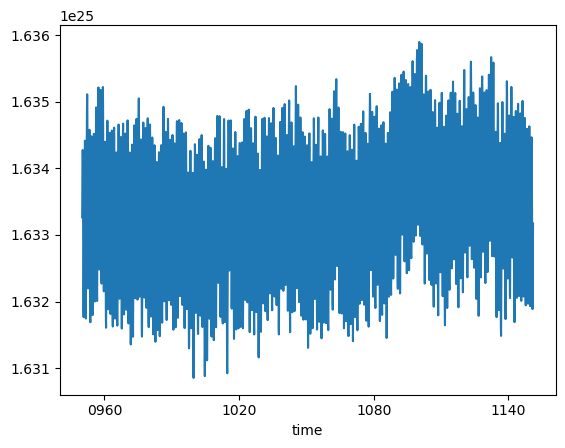

In [111]:
IO_HC.plot()

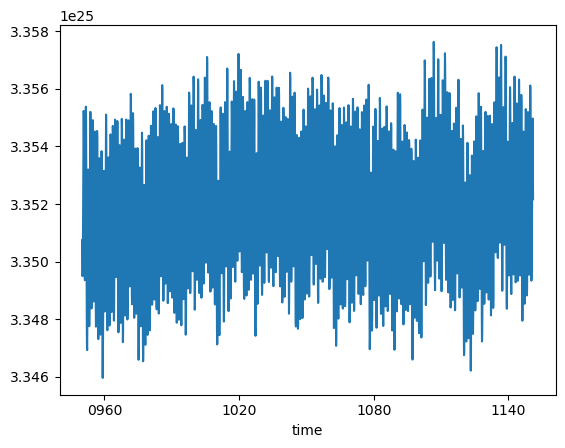

In [112]:
(PO_HC-IO_HC).plot()

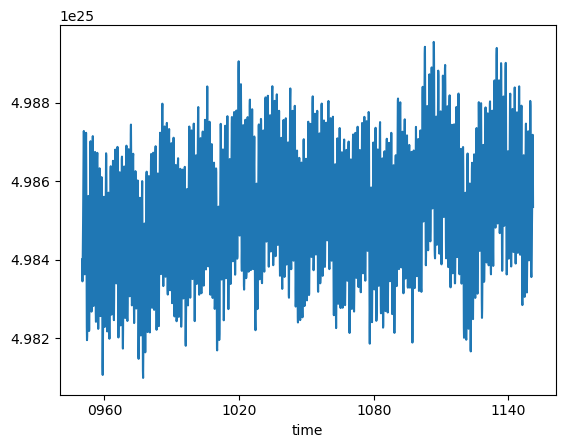

In [39]:
PO_HC.plot()

In [ ]:
IO_HC[600]

<xarray.DataArray ()>
array(1.6329932e+25, dtype=float32)
Coordinates:
    time     object 1000-01-16 12:00:00

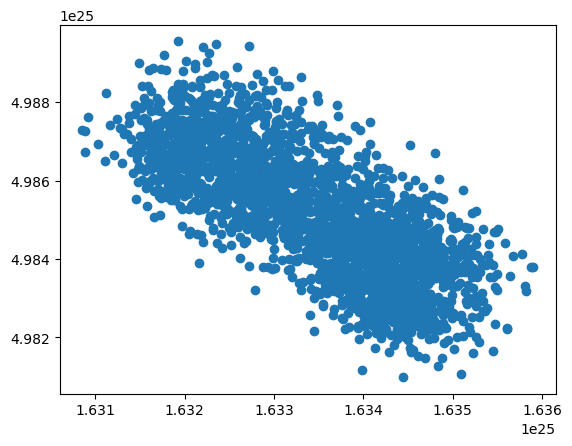

In [43]:
plt.scatter(IO_HC, PO_HC)

In [113]:
corr = correlate(IO_HC/1e25,PO_HC/1e25, method = "direct")


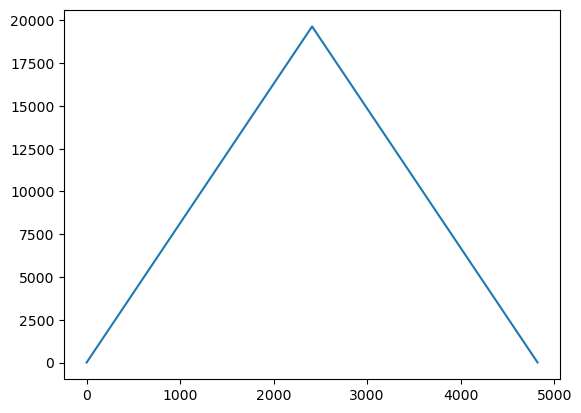

In [114]:
plt.plot(corr)

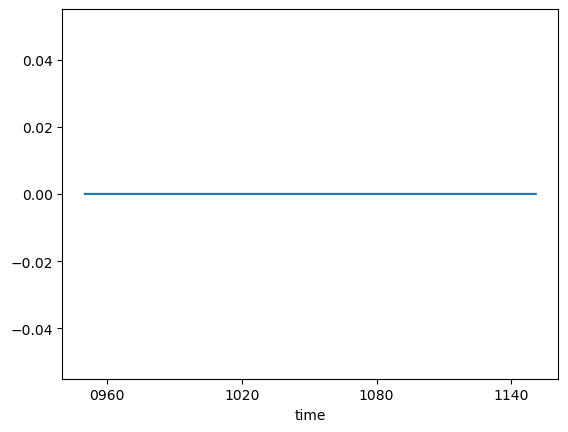

In [52]:
np.isnan(PO_HC).plot()

In [49]:
corr

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

Text(0.5, 1.0, 'OISSTV2 lagged corr')

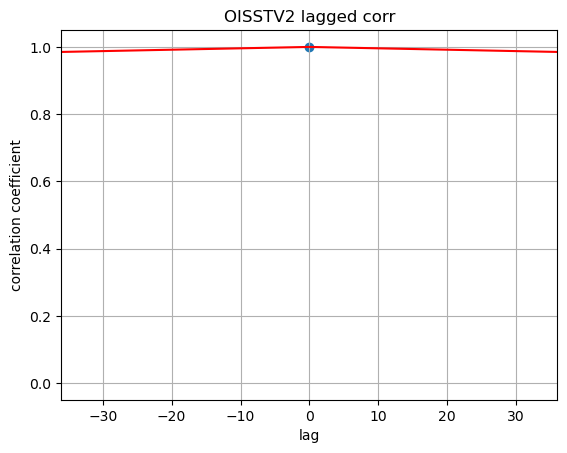

In [115]:
from scipy.signal import correlate,correlation_lags

lags = correlation_lags(IO_HC.size, PO_HC.size, mode="full")
corr = correlate(IO_HC/1e25,PO_HC/1e25)
corr /= corr[IO_HC.size - 1]
lag = lags[np.argmax(corr)]
fig, ax = plt.subplots()
ax.plot(lags, corr, 'r')
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)
ax.set_xlim(-36,36)
ax.scatter(lag, max(corr))
ax.set_title("OISSTV2 lagged corr")

In [116]:
def OHC_area(ds, depth, lat1, lat2, lon1, lon2, ):
    temp = ds.temp.drop(["geolat_t", "geolon_t"])
    dzt = ds.dht.drop(["geolat_t", "geolon_t"])
    area_t = ds.area_t.drop(["geolat_t", "geolon_t"])
    rho_0 = 1035 # kg m-3
    C_p = 3992.1 # J kg-1 K-1
    intermediate = (rho_0*C_p*temp*area_t*dzt).sel(st_ocean=slice(0.,depth))
    #roll_lon of intermediate array
    int_roll = roll_lon(intermediate)
    #select box    
    box = int_roll.sel(xt_ocean=slice(lon1, lon2), yt_ocean=slice(lat1, lat2))
    #now get OHC by integrating
    OHC =box.sum(['xt_ocean','yt_ocean','st_ocean'])
    return OHC

In [67]:
test = OHC_area(ctrl, 300, 0,10,110,150)

In [68]:
test2 = OHC_area(ctrl, 300, -15,-8,90,110)

In [69]:
test2 = test2.compute()

2023-09-22 15:00:49,926 - distributed.scheduler - ERROR - 
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/scheduler.py", line 4563, in update_graph
    plugin.update_graph(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/diagnostics/websocket.py", line 39, in update_graph
    self.socket.send("update_graph", {"client": client})
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/http/scheduler/info.py", line 216, in send
    self.write_message(data)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/tornado/websocket.py", line 336, in write_message
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError


In [70]:
test = test.compute()

2023-09-22 15:02:10,803 - distributed.scheduler - ERROR - 
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/scheduler.py", line 4563, in update_graph
    plugin.update_graph(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/diagnostics/websocket.py", line 39, in update_graph
    self.socket.send("update_graph", {"client": client})
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/http/scheduler/info.py", line 216, in send
    self.write_message(data)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/tornado/websocket.py", line 336, in write_message
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError


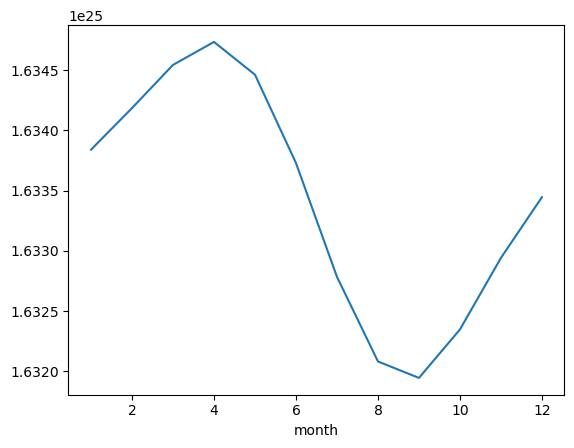

In [40]:
IO_HC.groupby("time.month").mean("time").plot()

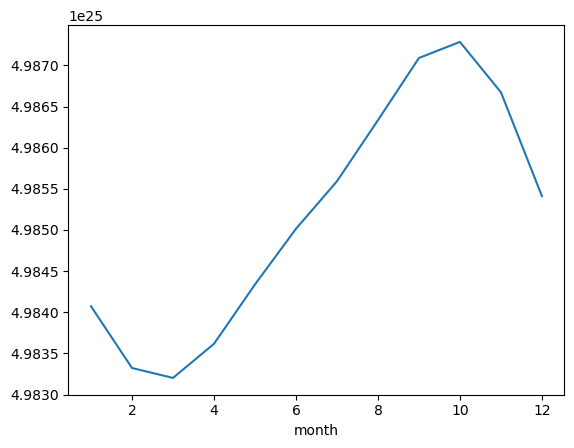

In [41]:
PO_HC.groupby("time.month").mean("time").plot()

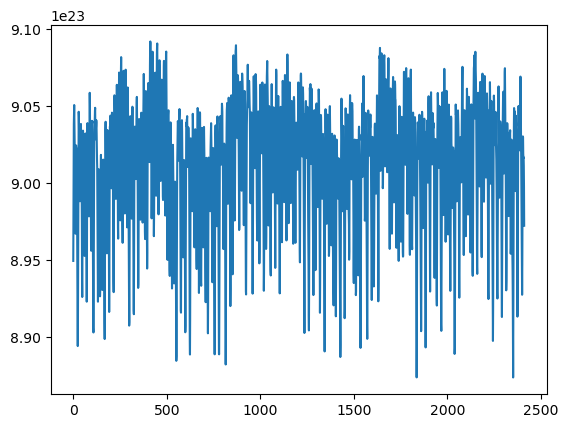

In [73]:
plt.plot(test-test2)

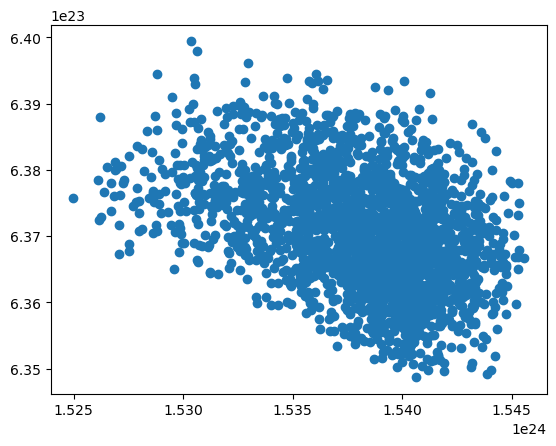

In [74]:
plt.scatter(test, test2)

In [41]:
from scipy.signal import correlate,correlation_lags


In [45]:
test

<xarray.DataArray (time: 2412)>
array([1.8413877e+24, 1.8401074e+24, 1.8406519e+24, ..., 1.8472392e+24,
       1.8460547e+24, 1.8447865e+24], dtype=float32)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1150-12-16 12:00:00

In [44]:
corr

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [61]:
temp = ctrl.temp
dzt = ctrl.dht
area_t = ctrl.area_t

In [ ]:
area_t

In [32]:
OHC = (rho_0*C_p*temp*area_t*dzt).sel(st_ocean=slice(0.,700.)).sum(['xt_ocean','yt_ocean','st_ocean'])

In [33]:
OHC = OHC.compute()

2023-09-15 14:45:46,910 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.28 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 14:45:48,691 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 14:45:54,129 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:36437 (pid=710032) exceeded 95% memory budget. Restarting...
2023-09-15 14:45:54,555 - distributed.nanny - WARNING - Restarting worker
2023-09-15 14:45:58,415 - distributed.worker.memory - WARNING - Unmanaged

In [28]:
OHC_grid = (rho_0*C_p*temp*dzt).sel(st_ocean=slice(0.,2000.)).sum(['st_ocean'])

In [38]:
OHC_grid_300 = (rho_0*C_p*temp*dzt).sel(st_ocean=slice(0.,300.)).sum(['st_ocean'])

In [ ]:
#units OHC_grid = kg m-3 *J kg-1 K-1 *K * m
#               = J m-2

In [29]:
OHC_grid = OHC_grid.compute()

2023-09-15 14:36:05,859 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.40 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 14:36:06,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 14:36:18,458 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [47]:
OHC_grid2 = (OHC_grid.groupby("time.month") - OHC_grid.groupby("time.month").mean("time")).drop("month")

2023-09-15 17:00:29,200 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.46 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 17:00:39,300 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.46 GiB -- Worker memory limit: 4.57 GiB


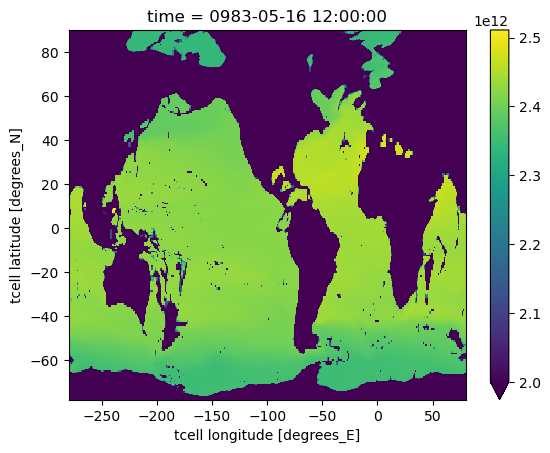

2023-09-15 17:12:43,197 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.46 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 17:12:53,198 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.46 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 17:13:03,199 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [59]:
OHC_grid[400].plot(vmin = 2e12)

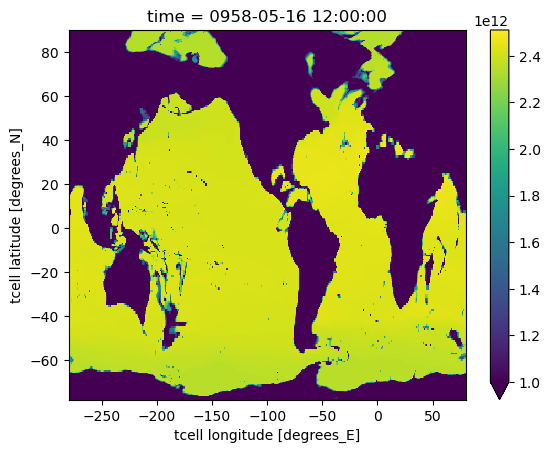

In [37]:
OHC_grid[100].plot(vmin = 1e12)

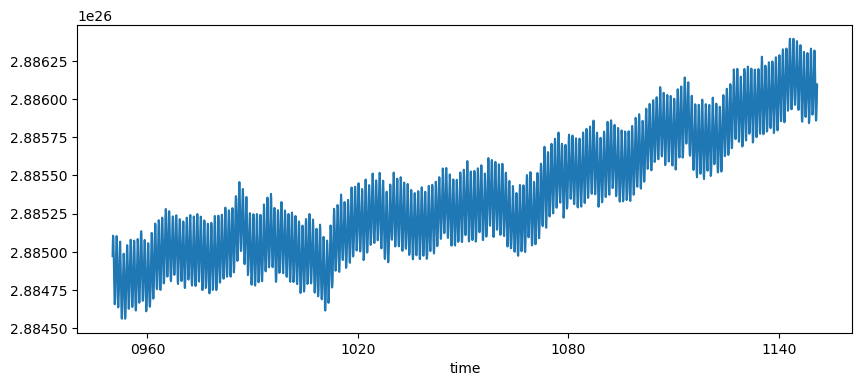

In [34]:
OHC.plot(figsize = (10,4))

In [ ]:
OHC[-1] - OHC[1]

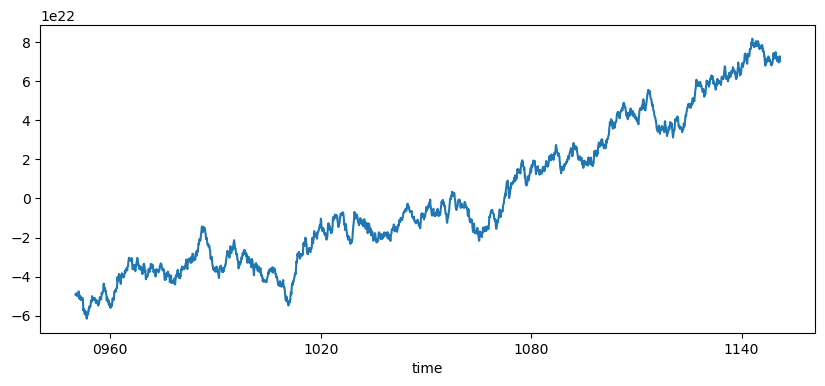

2023-09-15 17:08:01,698 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.46 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 17:08:11,698 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.46 GiB -- Worker memory limit: 4.57 GiB
2023-09-15 17:08:21,800 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [51]:
(OHC.groupby("time.month") -OHC.groupby("time.month").mean("time")).drop("month").plot(figsize = (10,4))

In [78]:
basin_mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/basin_mask_20111103.nc")

In [75]:
rest_mask =  xr.open_dataset("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_tropical_Pacific_Ocean_15S-15N_5degdampimg.nc", decode_times=False)

In [76]:
rest_mask1 = rest_mask.restore_mask[0,0].drop(("TIME", "DEPTH1_1"))

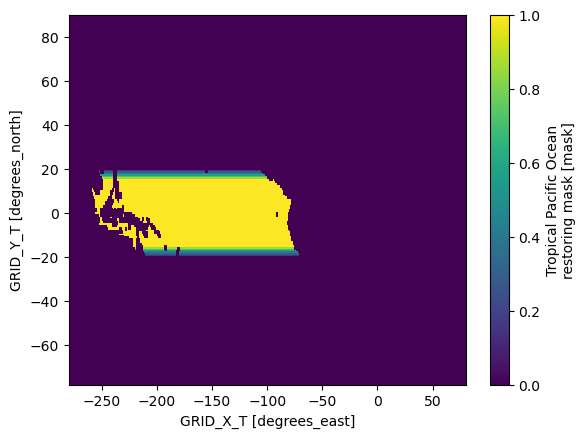

In [77]:
rest_mask1.plot()

In [8]:
#now lets make the IO and PO masks

In [79]:
basin_mask = basin_mask.BASIN_MASK[0].drop("ST_OCEAN1_1")

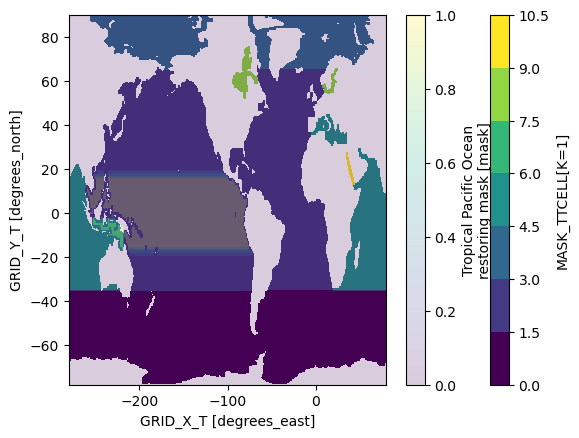

In [80]:
basin_mask.plot.contourf()
rest_mask1.plot(alpha = 0.2)

In [81]:
basin_mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/basin_mask_20111103.nc")
PO = basin_mask.where(basin_mask ==3)
IO = basin_mask.where(basin_mask ==5)

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

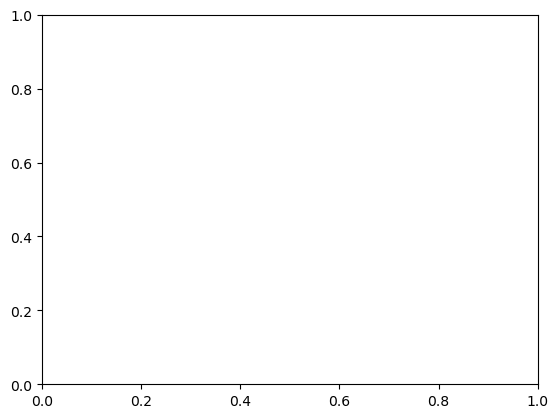

In [66]:
PO.plot()

In [84]:
mask =0

In [13]:
test = test.compute()

In [ ]:
test.plot()

In [5]:
#DS = DS.sel(xt_ocean = slice(-280,-200), yt_ocean = slice(-20,20), xu_ocean = slice(-280,-200), yu_ocean = slice(-20,20))

In [6]:
DS

<xarray.Dataset>
Dimensions:                          (xt_ocean: 80, yt_ocean: 98, time: 12,
                                      nv: 2, xu_ocean: 80, yu_ocean: 99,
                                      st_ocean: 50, st_edges_ocean: 51,
                                      sw_ocean: 50, sw_edges_ocean: 51,
                                      grid_xu_ocean: 360, grid_yt_ocean: 300,
                                      potrho: 80, potrho_edges: 81,
                                      grid_xt_ocean: 360, grid_yu_ocean: 300)
Coordinates: (12/20)
  * xt_ocean                         (xt_ocean) float64 -279.5 -278.5 ... -200.5
  * yt_ocean                         (yt_ocean) float64 -19.36 -18.59 ... 19.36
  * time                             (time) object 0974-01-16 12:00:00 ... 09...
  * nv                               (nv) float64 1.0 2.0
  * xu_ocean                         (xu_ocean) float64 -279.0 -278.0 ... -200.0
  * yu_ocean                         (yu_ocean) float64 -19.76 -18.97 ... 19.76
    ...                               ...
  * grid_xt_ocean                    (grid_xt_ocean) float64 -279.5 ... 79.5
  * grid_yu_ocean                    (grid_yu_ocean) float64 -77.75 ... 90.0
    geolat_c                         (yu_ocean, xu_ocean) float32 ...
    geolon_c                         (yu_ocean, xu_ocean) float32 ...
    geolat_t                         (yt_ocean, xt_ocean) float32 ...
    geolon_t                         (yt_ocean, xt_ocean) float32 ...
Data variables: (12/261)
    ht                               (yt_ocean, xt_ocean) float32 ...
    hu                               (yu_ocean, xu_ocean) float32 ...
    dxt                              (yt_ocean, xt_ocean) float32 ...
    dyt                              (yt_ocean, xt_ocean) float32 ...
    dxu                              (yu_ocean, xu_ocean) float32 ...
    dyu                              (yu_ocean, xu_ocean) float32 ...
    ...                               ...
    salt_rivermix                    (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    salt_sigma_diff                  (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    average_T1                       (time) object ...
    average_T2                       (time) object ...
    average_DT                       (time) timedelta64[ns] ...
    time_bounds                      (time, nv) timedelta64[ns] ...
Attributes:
    filename:   /scratch/w97/zg0866/archive/cm000/history/ocn/ocean_month.nc-...
    title:      AusCOM_CMIP5
    grid_type:  regular
    grid_tile:  N/A

In [7]:
hu = DS.hu
ht = DS.ht

In [8]:
thick= DS.dht

In [28]:
dens = DS.rho

In [30]:
dens

<xarray.DataArray 'rho' (time: 12, st_ocean: 50, yt_ocean: 300, xt_ocean: 360)>
[64800000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) object 0974-01-16 12:00:00 ... 0974-12-16 12:00:00
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    geolat_t  (yt_ocean, xt_ocean) float32 ...
    geolon_t  (yt_ocean, xt_ocean) float32 ...
Attributes:
    long_name:      in situ density
    units:          kg/m^3
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

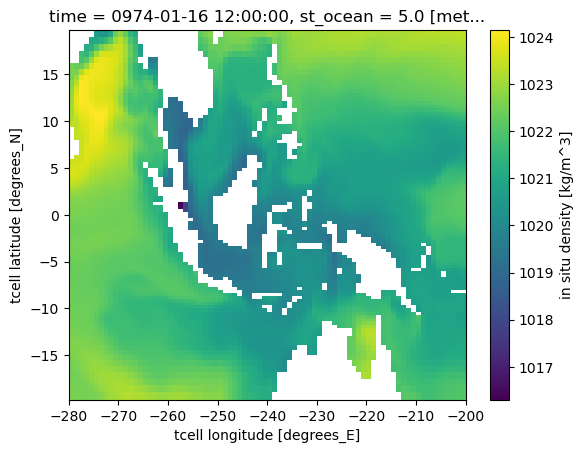

In [10]:
dens[0,0].plot()

In [11]:
DS.u

<xarray.DataArray 'u' (time: 12, st_ocean: 50, yu_ocean: 99, xu_ocean: 80)>
[4752000 values with dtype=float32]
Coordinates:
  * time      (time) object 0974-01-16 12:00:00 ... 0974-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.0 -278.0 -277.0 ... -202.0 -201.0 -200.0
  * yu_ocean  (yu_ocean) float64 -19.76 -18.97 -18.22 ... 18.22 18.97 19.76
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    geolat_c  (yu_ocean, xu_ocean) float32 ...
    geolon_c  (yu_ocean, xu_ocean) float32 ...
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

In [12]:
tx = DS.tx_trans

In [13]:
tx_5 = tx[:,0]

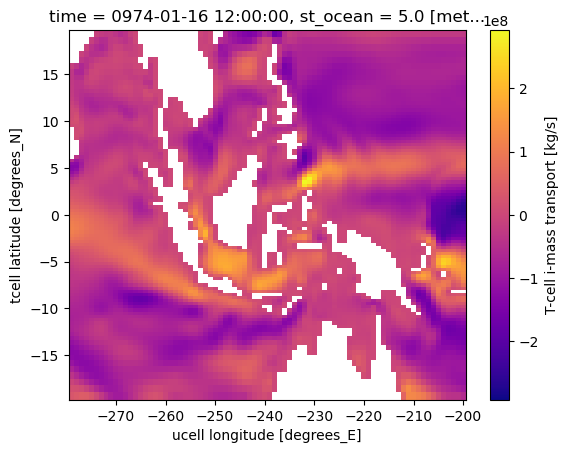

In [14]:
tx_5[0].plot(cmap = "plasma")

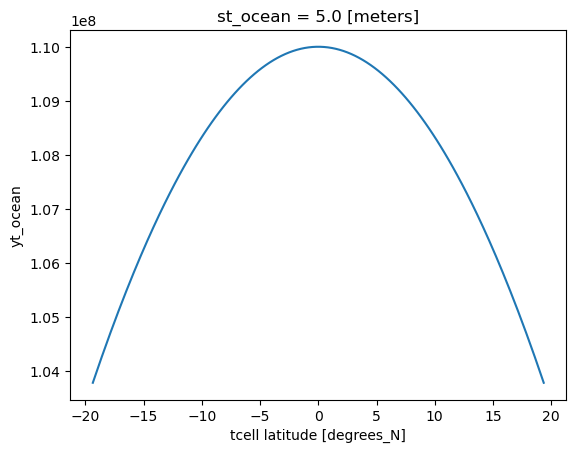

In [19]:
(np.cos(np.deg2rad(tx_5.yt_ocean))*110e6).plot()

In [24]:
test = tx_5*10*110e6

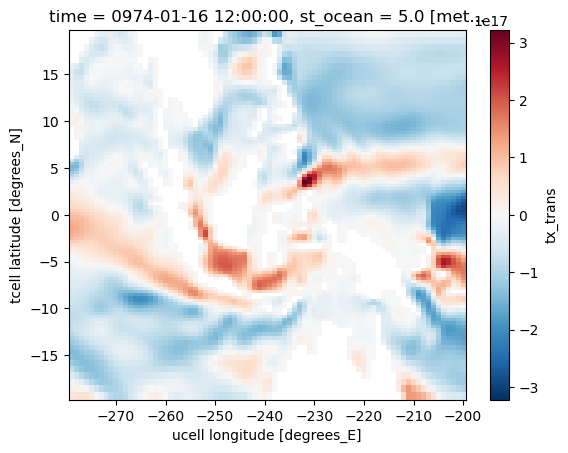

In [25]:
test[0].plot()

In [22]:
thick

<xarray.DataArray 'dht' (time: 12, st_ocean: 50, yt_ocean: 98, xt_ocean: 80)>
[4704000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 ... -202.5 -201.5 -200.5
  * yt_ocean  (yt_ocean) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
  * time      (time) object 0974-01-16 12:00:00 ... 0974-12-16 12:00:00
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    geolat_t  (yt_ocean, xt_ocean) float32 ...
    geolon_t  (yt_ocean, xt_ocean) float32 ...
Attributes:
    long_name:      t-cell thickness
    units:          m
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  cell_thickness

(array([  2605.,   6935.,  59607., 122130., 178058.,  62540.,  22091.,
          8413.,    917.,    437.]),
 array([-2.9290845e+17, -2.3074918e+17, -1.6858989e+17, -1.0643061e+17,
        -4.4271329e+16,  1.7887955e+16,  8.0047238e+16,  1.4220652e+17,
         2.0436580e+17,  2.6652509e+17,  3.2868436e+17], dtype=float32),
 <BarContainer object of 10 artists>)

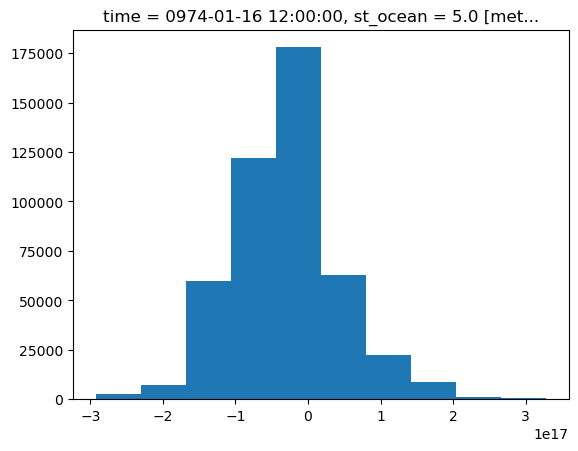

In [23]:
test[0].plot()

In [ ]:
test = tx/dens

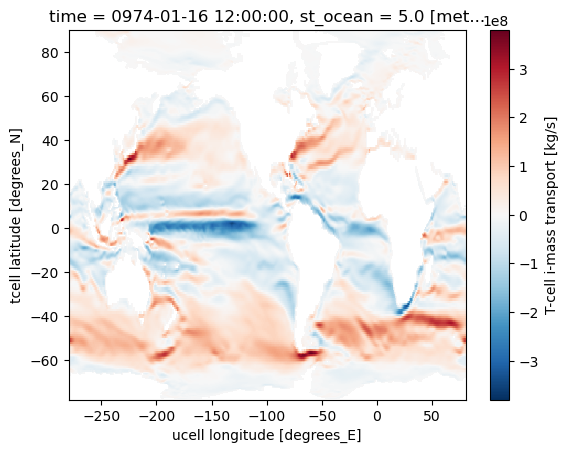

In [28]:
test[0,0].plot()